In [1]:
%load_ext autoreload
%autoreload 2
from configs import project_config
import pickle
import numpy as np
import torch
import os
from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion
import matplotlib.pyplot as plt
from configs.RecursiveVPSDE.Markovian_fQuadSinHF.recursive_Markovian_PostMeanScore_fQuadSinHF2_LowFTh_T256_H05_tl_110data_StbleTgt import get_config
#from configs.RecursiveVPSDE.Markovian_fSinLog.recursive_Markovian_PostMeanScore_fSinLog_LowFTh_T256_H05_tl_110data_StbleTgt import get_config
#from configs.RecursiveVPSDE.Markovian_fBiPot.recursive_Markovian_PostMeanScore_fBiPot_LowFTh_T256_H05_tl_110data_StbleTgt
#import get_config

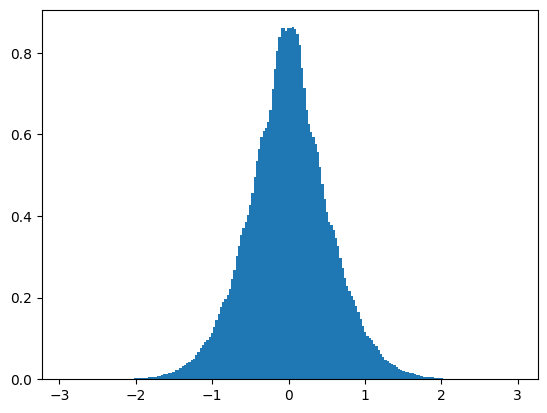

In [25]:
config = get_config()

data = np.load(config.data_path, allow_pickle=True).flatten()

n = (plt.hist(data, bins=200, density=True))

In [39]:
100*(n[0][(np.abs(n[1])>1.5)[:-1]].sum()/n[0].sum())

0.928149572551888

In [3]:
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalMarkovianTSPostMeanScoreMatching import \
    ConditionalMarkovianTSPostMeanScoreMatching
config = get_config()
scoreModel = ConditionalMarkovianTSPostMeanScoreMatching(
            *config.model_parameters)
model_dir = "/".join(config.scoreNet_trained_path.split("/")[:-1]) + "/"
entered = False
for file in os.listdir(model_dir):
    if config.scoreNet_trained_path in os.path.join(model_dir, file) and "EE" in file:
        print(file)
        entered = True
        scoreModel.load_state_dict(torch.load(os.path.join(model_dir, file)))
sd = scoreModel.state_dict()
for name, tensor in sd.items():
    if "hybrid" in name:
        print(name, tensor.shape)
        print(tensor)

trained_rec_ST_0002FTh_PM_MLP_2LFac_fQuadSinHF_VPSDE_T256_Ndiff10000_Tdiff1000e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT3906e-03_05a_004b_250c_MLP_H4_CUp20_tl110_EENEp70
mlp_state_mapper.hybrid.W torch.Size([16, 1])
tensor([[-0.0262],
        [-0.7009],
        [ 0.4943],
        [-0.1586],
        [ 0.9479],
        [-1.1246],
        [-0.7471],
        [-1.0535],
        [ 0.8326],
        [-1.4140],
        [-0.2723],
        [-0.4686],
        [ 0.1464],
        [-0.5262],
        [-0.2101],
        [ 1.6077]])
mlp_state_mapper.hybrid.b torch.Size([16])
tensor([3.0544, 0.2993, 2.2178, 1.5376, 2.3971, 1.8322, 3.3152, 3.5209, 3.2597,
        2.7412, 1.7417, 5.6747, 6.0971, 1.2254, 4.0100, 3.7055])
mlp_state_mapper.hybrid.log_scale torch.Size([16])
tensor([-0.3378,  4.4751,  2.0398,  4.2830,  1.9347,  2.9838,  4.6357,  6.2411,
         3.0534,  0.0225,  2.3062,  5.8188,  2.0724,  1.9358,  0.8841,  0.5672])
mlp_state_mapper.hybrid.gate_logits torch.Size([3

In [4]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

In [5]:
def rmse_ignore_nans(y_true, y_pred):
    return np.nanmean((y_true-y_pred)**2)

def plot_drift_estimator(mean, mean_min, mean_max, numpy_Xs, true_drift, Nepoch, dirname, label, toSave: bool = True):
    if "BiPot" in config.data_path:
        ts_type_str = "fBiPot"
    elif "SinLog" in config.data_path:
        ts_type_str = "fSinLog"
    elif "QuadSinHF" in config.data_path:
        ts_type_str = "fQuadSinHF2"
    fig, ax = plt.subplots(figsize=(14, 9))
    ax.scatter(numpy_Xs, true_drift, color="red", label="True Drift")
    ymin = mean - mean_min
    ymax = mean_max - mean
    ymin[ymin < 0.] = 0.
    ymax[ymax < 0.] = 0.
    plt.errorbar(numpy_Xs, mean, yerr=[ymin, ymax], xerr=None, fmt='o', color="blue", alpha=0.4)
    plt.scatter(numpy_Xs, mean, label="Estimated Drift", color="blue")
    ax.set_title(rf"Score Estimator for {label}", fontsize=40)
    ax.tick_params(labelsize=38)
    ax.set_xlabel("State $X$", fontsize=38)
    ax.set_ylabel("Drift Value", fontsize=38)
    ax.legend(fontsize=24)
    plt.grid(True)
    plt.tight_layout()
    if toSave:
        plt.savefig((root_dir +f"DiffusionModelPresentationImages/TSPM_Markovian/{dirname}/TSPM_MLP_PM_ST_{ts_type_str}_DriftEvalExp_{Nepoch}Nep_{config.loss_factor}LFac").replace(
                ".", "") + ".png", bbox_inches='tight')
    plt.show()
    plt.close()
def plot_ewma_losses(epochs, losses):
    start_idx = 0
    def compute_ema(loss_tensor, beta):
        ema_values = np.zeros_like(loss_tensor)  # Initialize EMA tensor
        ema_values[0] = loss_tensor[0]  # First value stays the same

        for i in range(1, len(loss_tensor)):
            ema_values[i] = beta * ema_values[i - 1] + (1 - beta) * loss_tensor[i]

        return ema_values
    # Define EMA decay rates
    beta_short = 0.9   # Short-term trend (reacts quickly)
    beta_long = 0.92   # Long-term trend (smoother)

    # Compute EMAs
    short_term_ema = compute_ema(losses, beta_short)
    long_term_ema = compute_ema(losses, beta_long)
    plt.scatter(epochs[start_idx:], (short_term_ema[start_idx:]),s=2, label="Short Term Loss")
    print(np.min(short_term_ema[start_idx:]), np.min(long_term_ema[start_idx:]))
    print(long_term_ema[-1])
    plt.yscale("log")
    plt.legend()
    plt.show()
    plt.scatter(epochs[start_idx:], (long_term_ema[start_idx:]),s=2, label="Long Term Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()
    return long_term_ema

In [6]:
config = get_config()
#assert config.enforce_fourier_mean_reg
root_dir ="/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"

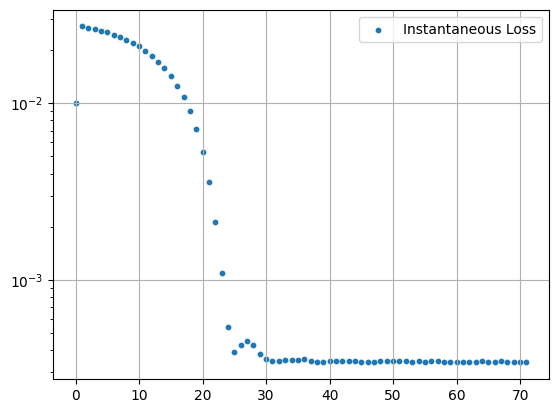

71

In [7]:
with open((config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/")+ "_loss"), 'rb') as f:
        losses = (np.array(pickle.load(f)).astype(float))
Nepochs_losses = np.arange(losses.shape[0])
plt.scatter(Nepochs_losses,  losses, s=10, label="Instantaneous Loss")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()
plt.close()
Nepochs_losses[-1]

0.0004122853651958577 0.0005550621408188368
0.0005550621408188368


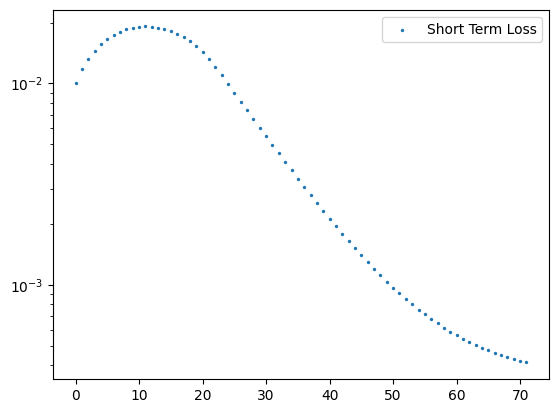

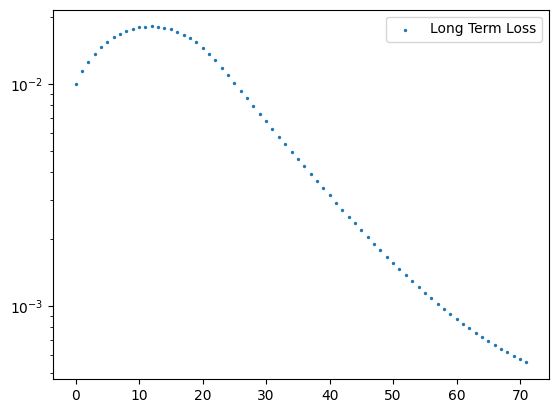

In [8]:
long_term_ema = plot_ewma_losses(epochs=Nepochs_losses, losses=losses)

In [9]:
best_val_loss = long_term_ema[0]
num_bads = 0
for i in range(long_term_ema.shape[0]):
    if num_bads > 50:
        break
    bad = long_term_ema[i] >= best_val_loss *(1.-1e-3)
    if bad:
        num_bads += 1
        print(i, (1-long_term_ema[i]/best_val_loss)*1e3, num_bads)
    else:
        num_bads = 0
        print(i, (1-long_term_ema[i]/best_val_loss)*1e3)
    if long_term_ema[i] < best_val_loss*(1.-1e-3):
        best_val_loss = long_term_ema[i]

0 0.0 1
1 -137.90490444438365 2
2 -261.2236181136502 3
3 -370.83008963488794 4
4 -467.39854618383237 5
5 -551.5134045275256 6
6 -623.3821065639968 7
7 -683.5641591675897 8
8 -732.2883007087709 9
9 -769.7622994692352 10
10 -796.0914715303633 11
11 -811.1551016979737 12
12 -814.9838153827111 13
13 -807.7422188447603 14
14 -789.439290515678 15
15 -760.1301453015623 16
16 -720.1115434971443 17
17 -669.4616470128518 18
18 -608.339531053625 19
19 -537.12414730114 20
20 -456.6364092668456 21
21 -368.71128142694687 22
22 -276.15868639185925 23
23 -182.8147626391743 24
24 -92.52189725707427 25
25 -8.254975566023948 26
26 68.99156718302513
27 76.09951133246263
28 76.03053595743702
29 76.14969826140717
30 76.12893684499511
31 75.9175400101334
32 75.52881183270665
33 75.13549207756954
34 74.72782562259839
35 74.30583782188394
36 73.80996185982657
37 73.45976722135772
38 72.99020015590085
39 72.45330202149114
40 71.79365233488821
41 71.13778881526744
42 70.42284114125385
43 69.74210081844612
44 69.

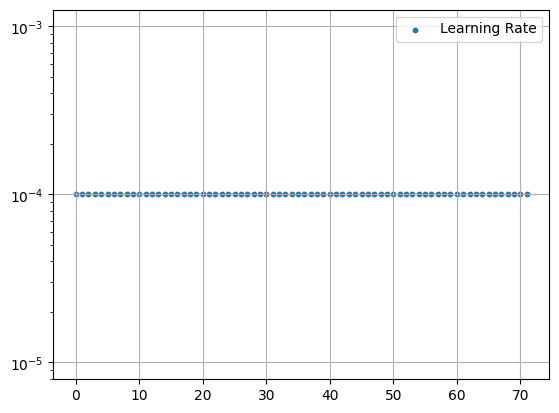

In [10]:
with open((config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/")+ "_loss_LR"), 'rb') as f:
        LRs = (np.array(pickle.load(f)).astype(float))
start = 0
end = -1
plt.scatter(np.arange(LRs.shape[0]),  LRs, s=10, label="Learning Rate")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()
plt.close()

In [11]:
root_score_dir = ""
if "fQuadSin" in config.data_path:
    minx = -1.5
    assert config.sin_space_scale == 25.
    ts_type = "fQuadSin2"
    include = (f"{config.deltaT:.3e}dT_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c").replace(
        ".", "")
    root_score_dir = root_dir + f"ExperimentResults/TSPM_Markovian/QuadSinHF2/"
elif "fBiPot" in config.data_path:
    minx = -1.5
    ts_type = "fBiPot"
    include = (f"{config.deltaT:.3e}dT_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c").replace(
        ".", "")
    root_score_dir = root_dir + f"ExperimentResults/TSPM_Markovian/BiPot/"
elif "fSinLog" in config.data_path:
    minx = -1.5
    ts_type = "fSinLog"
    include = (f"{config.deltaT:.3e}dT_{config.log_space_scale}b_{config.sin_space_scale}c").replace(
        ".", "")
    root_score_dir = root_dir + f"ExperimentResults/TSPM_Markovian/SinLog/"
if not config.stable_target:
    root_score_dir += "NSTgt/"
maxx = -minx

In [12]:
root_score_dir

'/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/QuadSinHF2/'

In [13]:
def get_drift_files(config, include, ts_type_str, root_score_dir):
    ts_type = f"{ts_type_str}"
    driftevalexp_files = []
    driftoostrack_true_files = []
    driftoostrack_local_files = []
    for file in os.listdir(root_score_dir):
        #print(file)
        if "MLP" in file and ts_type in file and include in file:
            if (("ST" in ts_type_str and "_ST_" in file) or (("ST" not in ts_type_str and "_ST_" not in file))):
                if "muhats" in file and "DriftEvalExp" in file :
                    print(file)
                    driftevalexp_files.append(root_score_dir+file)
                elif "OOSDriftTrack" in file and "true" in file:
                    driftoostrack_true_files.append(root_score_dir+file)
                elif "OOSDriftTrack" in file and "global" in file:
                    driftoostrack_local_files.append(root_score_dir+file)
    def extract_bw_drift_eval_exp_number(s):
        match = s.split("Nep_")[0].split("_")[-1]
        return int(match)
    def extract_bw_drift_track_number(s):
        match = s.split("Nep_")[0].split("_")[-1]
        return int(match)
    driftevalexp_files = sorted(driftevalexp_files, key=extract_bw_drift_eval_exp_number)
    driftoostrack_true_files = sorted(driftoostrack_true_files, key=extract_bw_drift_track_number)
    driftoostrack_local_files = sorted(driftoostrack_local_files, key=extract_bw_drift_track_number)
    Nepochs_track = [extract_bw_drift_track_number(f) for f in driftoostrack_true_files]
    Nepochs_drifteval = [extract_bw_drift_eval_exp_number(f) for f in driftevalexp_files]
    return driftevalexp_files, driftoostrack_true_files, driftoostrack_local_files, Nepochs_track, Nepochs_drifteval

In [14]:
NSTgt = "NSTgt" if not config.stable_target else ""
NSTgt += "NFMReg" if not config.enforce_fourier_mean_reg else ""
if "BiPot" in config.data_path:
    ts_type_str = f"ST_{config.feat_thresh:.3f}FTh_{NSTgt}fBiPot".replace(".", "")
    dirname = "BiPot"
    label = "$\mu_{3}$"
elif "QuadSinHF" in config.data_path:
    ts_type_str = f"ST_{config.feat_thresh:.3f}FTh_{NSTgt}fQuadSinHF".replace(".","")
    dirname = "QuadSinHF2"
    label = "$\mu_{2}$"
elif "SinLog" in config.data_path:
    ts_type_str = f"ST_{config.feat_thresh:.3f}FTh_{NSTgt}fSinLog".replace(".","")
    dirname = "SinLog"
    label = "$\mu_{1}$"
driftevalexp_files, driftoostrack_true_files, driftoostrack_local_files, Nepochs_track, Nepochs_drifteval = get_drift_files(config=config, include=include, ts_type_str=ts_type_str, root_score_dir=root_score_dir)

TSPM_MLP_ST_0002FTh_fQuadSinHF_DriftEvalExp_15Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_BetaMax20e+01_muhats.npy
TSPM_MLP_ST_0002FTh_fQuadSinHF_DriftEvalExp_33Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_BetaMax20e+01_muhats.npy
TSPM_MLP_ST_0002FTh_fQuadSinHF_DriftEvalExp_27Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_BetaMax20e+01_muhats.npy
TSPM_MLP_ST_0002FTh_fQuadSinHF_DriftEvalExp_29Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_BetaMax20e+01_muhats.npy
TSPM_MLP_ST_0002FTh_fQuadSinHF_DriftEvalExp_5Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_BetaMax20e+01_muhats.npy
TSPM_MLP_ST_0002FTh_fQuadSinHF_DriftEvalExp_66Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_BetaMax20e+01_muhats.npy
TSPM_MLP_ST_0002FTh_fQuadSinHF_DriftEvalExp_40Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_BetaMax20e+01_muhats.npy
TSPM_MLP_ST_0002FTh_fQuadSinHF_DriftEvalExp_72Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_BetaMax20e+01_muhats.npy
TSPM_MLP_ST_0002FTh_fQuadSinHF_DriftEvalE

In [15]:
eval_exp_rmses = {}
for f in zip(*[Nepochs_drifteval, driftevalexp_files]):
    Nepoch = f[0]
    file = f[1]
    try:
        muhats = torch.Tensor(np.load(file, allow_pickle=True))
        Xshape = muhats.shape[0]
        Xs = torch.Tensor(np.linspace(-1.5,1.5,Xshape))
        if "BiPot" in config.data_path:
            true_drifts = -(4.*config.quartic_coeff * np.power(Xs, 3) + 2.*config.quad_coeff * Xs + config.const).numpy()
        elif "QuadSin" in config.data_path:
            true_drifts = (-2. * config.quad_coeff * Xs + config.sin_coeff * config.sin_space_scale * np.sin(
        config.sin_space_scale * Xs)).numpy()
        elif "SinLog" in config.data_path:
            true_drifts = (-np.sin(config.sin_space_scale*Xs)*np.log(1+config.log_space_scale*np.abs(Xs))/config.sin_space_scale).numpy()
        mu_hats = muhats[:, -1, :].reshape(muhats.shape[0], muhats.shape[2]*1).mean(dim=-1).numpy()
        rmse = rmse_ignore_nans(true_drifts, mu_hats).astype(np.float64)
        eval_exp_rmses.update({Nepoch: round(rmse, 6)})
    except [FileNotFoundError, pickle.UnpicklingError] as e:
        continue
Nepochs_drifteval = np.array(list(eval_exp_rmses.keys())).flatten()
eval_exp_rmses

{1: 641.543335,
 2: 630.927429,
 3: 619.108398,
 4: 605.842773,
 5: 590.975647,
 6: 574.295837,
 7: 555.510376,
 8: 534.446472,
 9: 511.019226,
 10: 485.017609,
 11: 456.102112,
 12: 424.495911,
 13: 390.26828,
 14: 353.038055,
 15: 313.954926,
 16: 272.898376,
 17: 229.005859,
 18: 182.77002,
 19: 136.206619,
 20: 91.956787,
 21: 52.944984,
 22: 23.587833,
 23: 6.418133,
 24: 1.517345,
 25: 4.227087,
 26: 7.380733,
 27: 7.152565,
 28: 4.85245,
 29: 2.719955,
 30: 1.708488,
 31: 1.505901,
 32: 1.524364,
 33: 1.525249,
 34: 1.504224,
 35: 1.483548,
 36: 1.506608,
 37: 1.519449,
 38: 1.5508,
 39: 1.506596,
 40: 1.503148,
 41: 1.484995,
 42: 1.500542,
 43: 1.492727,
 44: 1.473805,
 45: 1.464506,
 46: 1.483384,
 47: 1.471857,
 48: 1.478292,
 49: 1.480475,
 50: 1.465867,
 51: 1.4736,
 52: 1.477317,
 53: 1.451385,
 54: 1.463289,
 55: 1.464286,
 56: 1.453887,
 57: 1.439777,
 58: 1.450148,
 59: 1.453941,
 60: 1.443497,
 61: 1.431134,
 62: 1.455898,
 63: 1.447546,
 64: 1.433649,
 65: 1.431211,


In [16]:
drift_track_rmses = {}
for f in zip(*[Nepochs_track, driftoostrack_true_files, driftoostrack_local_files]):
    Nepoch = f[0]
    true = f[1]
    local = f[2]
    try:
        all_true_states = np.load(true, allow_pickle=True)
        all_local_states= np.load(local,allow_pickle=True)
        global_error = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        total_local_errors = np.sqrt(np.mean(global_error.reshape(-1, global_error.shape[-1]), axis=0))
        drift_track_rmses.update({Nepoch:total_local_errors[-1]})
    except pickle.UnpicklingError as e:
        print(e)
        continue
    except (FileNotFoundError, ValueError) as e:
        print(e)
        continue
Nepochs_track= np.array(list(drift_track_rmses.keys())).flatten()

In [17]:
common_epochs = np.intersect1d(np.intersect1d(np.intersect1d(Nepochs_losses, Nepochs_drifteval), Nepochs_track), np.arange(10, 3500))
start_idx = 0
common_epochs = common_epochs[start_idx:]
losses_idx = [np.argwhere(c == Nepochs_losses)[0,0] for c in common_epochs]
evalexp_idx = [np.argwhere(c == Nepochs_drifteval)[0,0] for c in common_epochs]
red_losses = losses[losses_idx]
eval_rmses = np.array(list(eval_exp_rmses.values()))[evalexp_idx]
track_idx = [np.argwhere(c == Nepochs_track)[0,0] for c in common_epochs]
track_rmses = np.array(list(drift_track_rmses.values()))[track_idx]

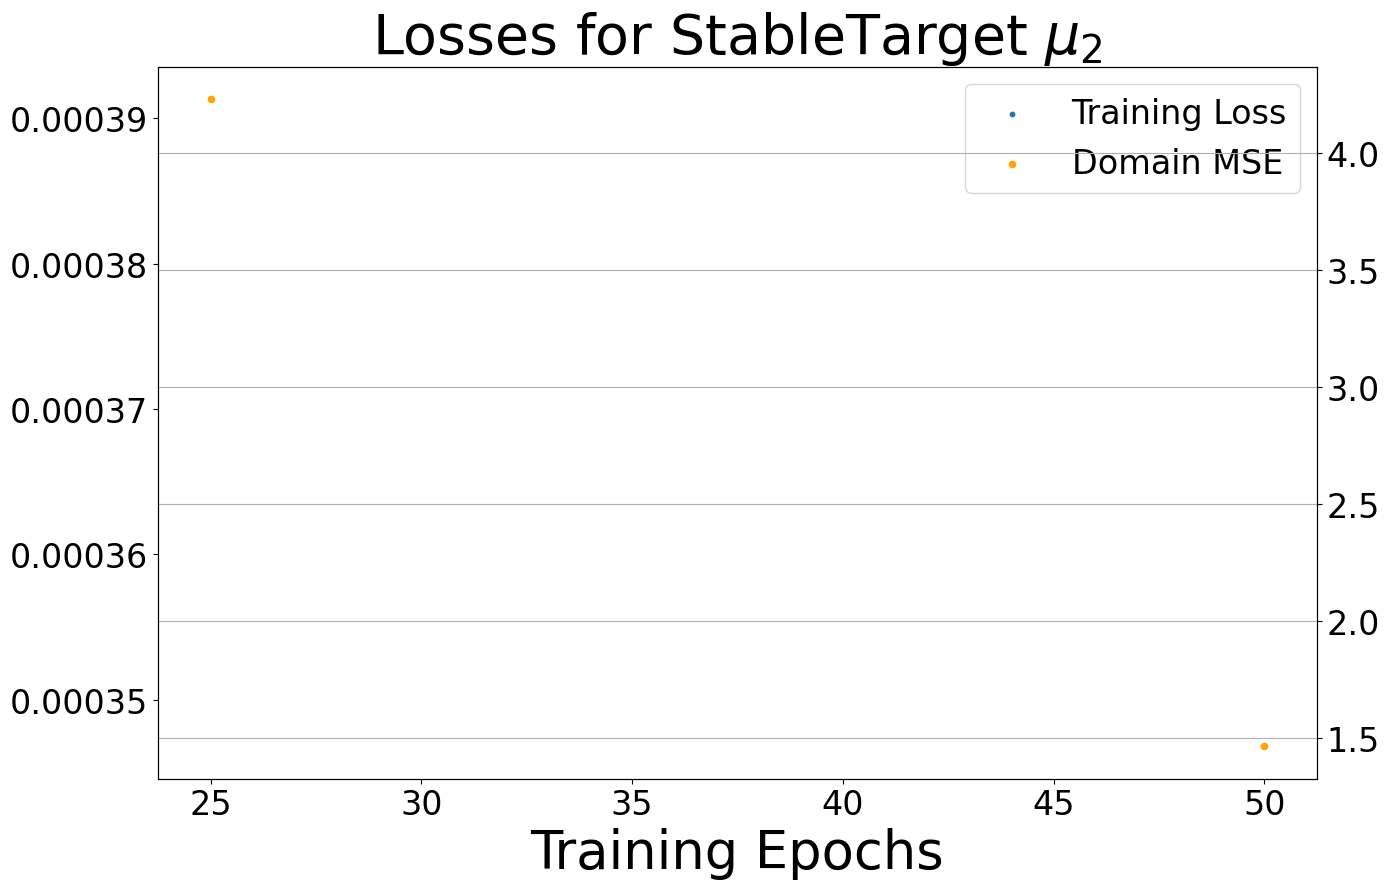

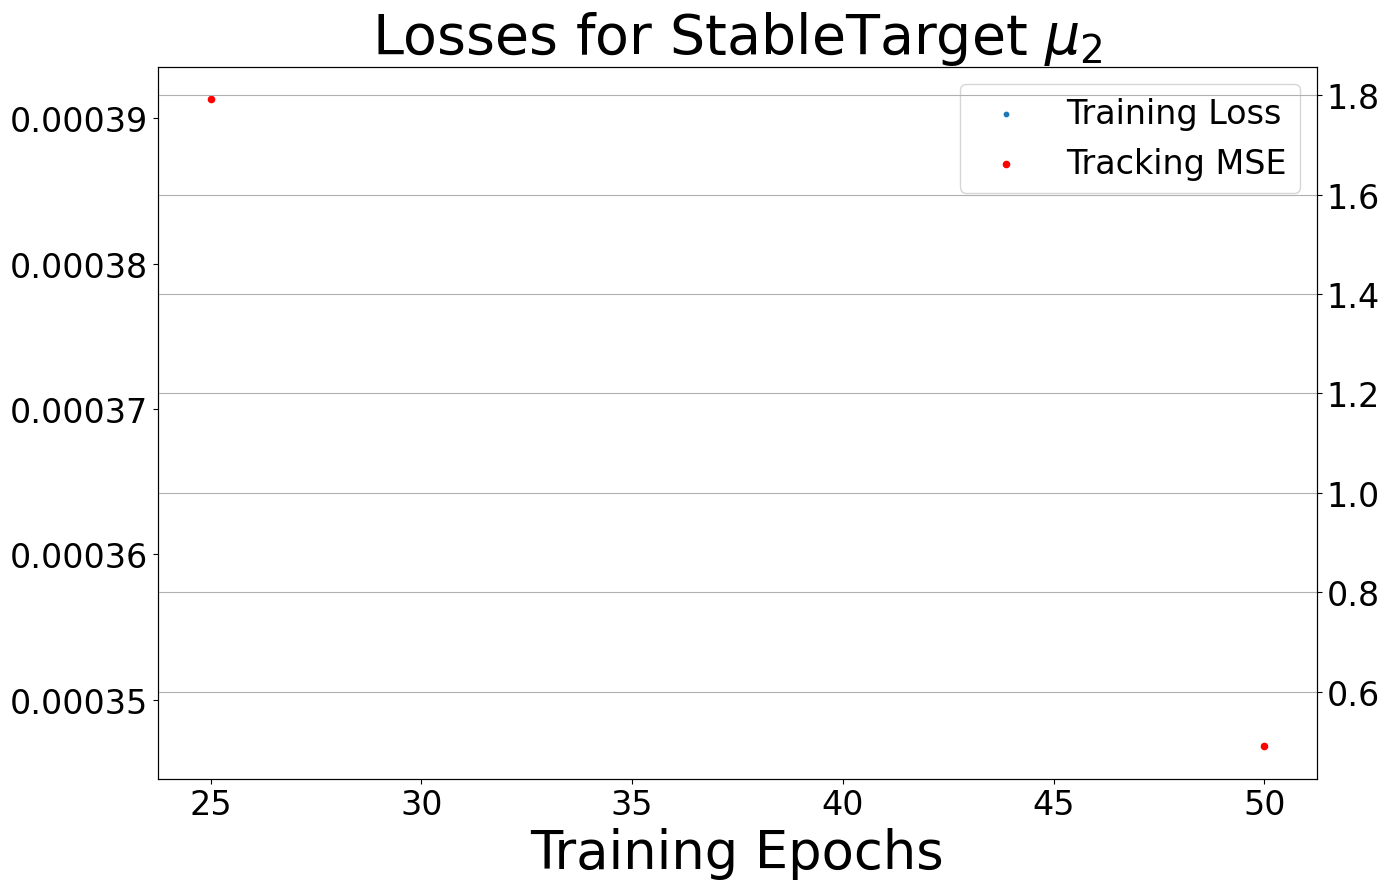

In [18]:
toSave = False
fig, ax = plt.subplots(figsize=(14,9))
sc1 = ax.scatter(common_epochs, red_losses, s=10, label="Training Loss")
ax.tick_params(axis="both",labelsize=24)
ax2 = ax.twinx()
sc2 = ax2.scatter(common_epochs, eval_rmses, s=20, color="orange",label="Domain MSE")
ax.set_xlabel("Training Epochs", fontsize=38)
ax.set_title(rf"Losses for StableTarget {label}", fontsize=40)
ax.tick_params(axis="both",labelsize=24)
ax2.tick_params(axis="both",labelsize=24)
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
ax.legend(handles, labels, fontsize=24)
if toSave:
    plt.savefig((root_dir +f"DiffusionModelPresentationImages/TSPM_Markovian/{dirname}/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_{ts_type}_LossesEvalExp_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
plt.grid(True)
plt.show()
plt.close()
fig, ax = plt.subplots(figsize=(14,9))
sc1 = ax.scatter(common_epochs, red_losses, s=10, label="Training Loss")
ax2 = ax.twinx()
sc2 = ax2.scatter(common_epochs, track_rmses, s=20, color="red",label="Tracking MSE")
ax.set_xlabel("Training Epochs", fontsize=38)
ax.set_title(rf"Losses for StableTarget {label}", fontsize=40)
ax.tick_params(axis="both",labelsize=24)
ax2.tick_params(axis="both",labelsize=24)
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
# Add a single legend on ax1
ax.legend(handles, labels, fontsize=24)
if toSave:
    plt.savefig((root_dir + f"DiffusionModelPresentationImages/TSPM_Markovian/{dirname}/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_{ts_type}_LossesTrack_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
plt.grid(True)
plt.show()
plt.close()

0.00038685651088599116 0.0003877470677252859
0.0003877470677252859


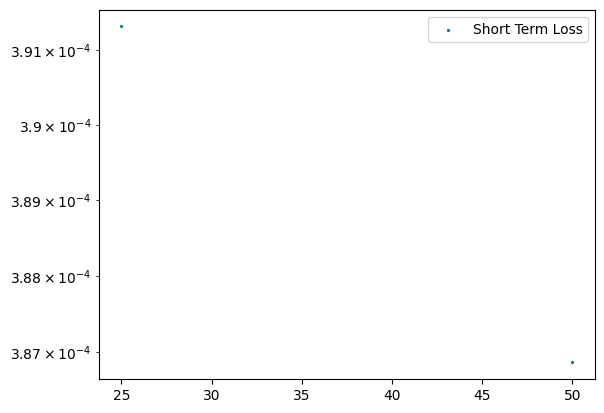

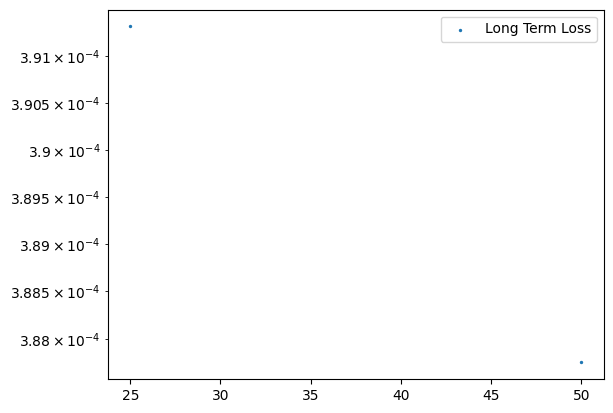

array([0.00039131, 0.00038775])

In [19]:
plot_ewma_losses(epochs=common_epochs, losses=red_losses)

torch.Size([256, 100])


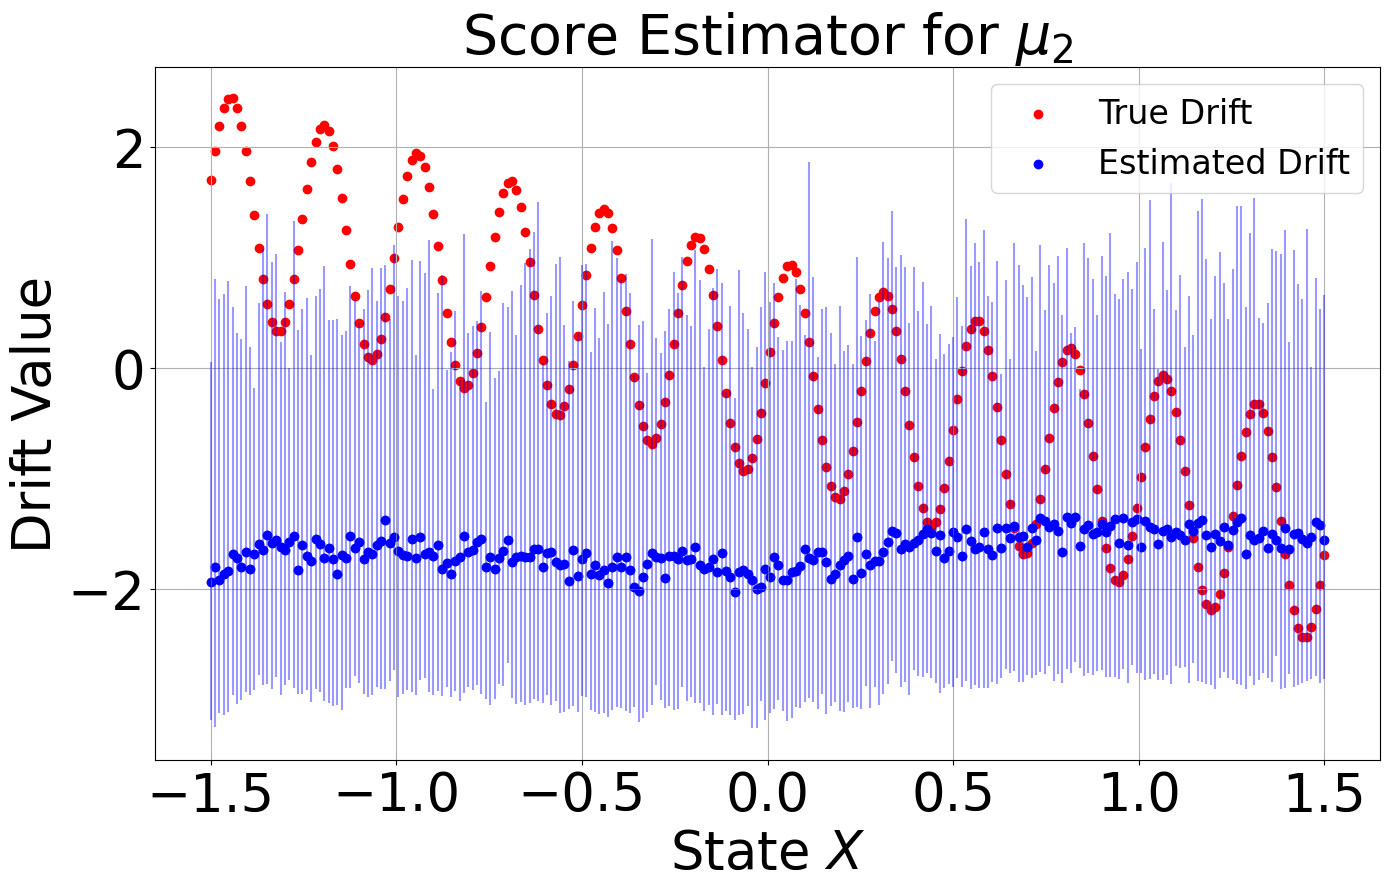

MSE 4.227087020874023 at Nepoch 25

/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/QuadSinHF2/TSPM_MLP_ST_0002FTh_fQuadSinHF_DriftEvalExp_25Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_BetaMax20e+01_muhats.npy
torch.Size([256, 100])


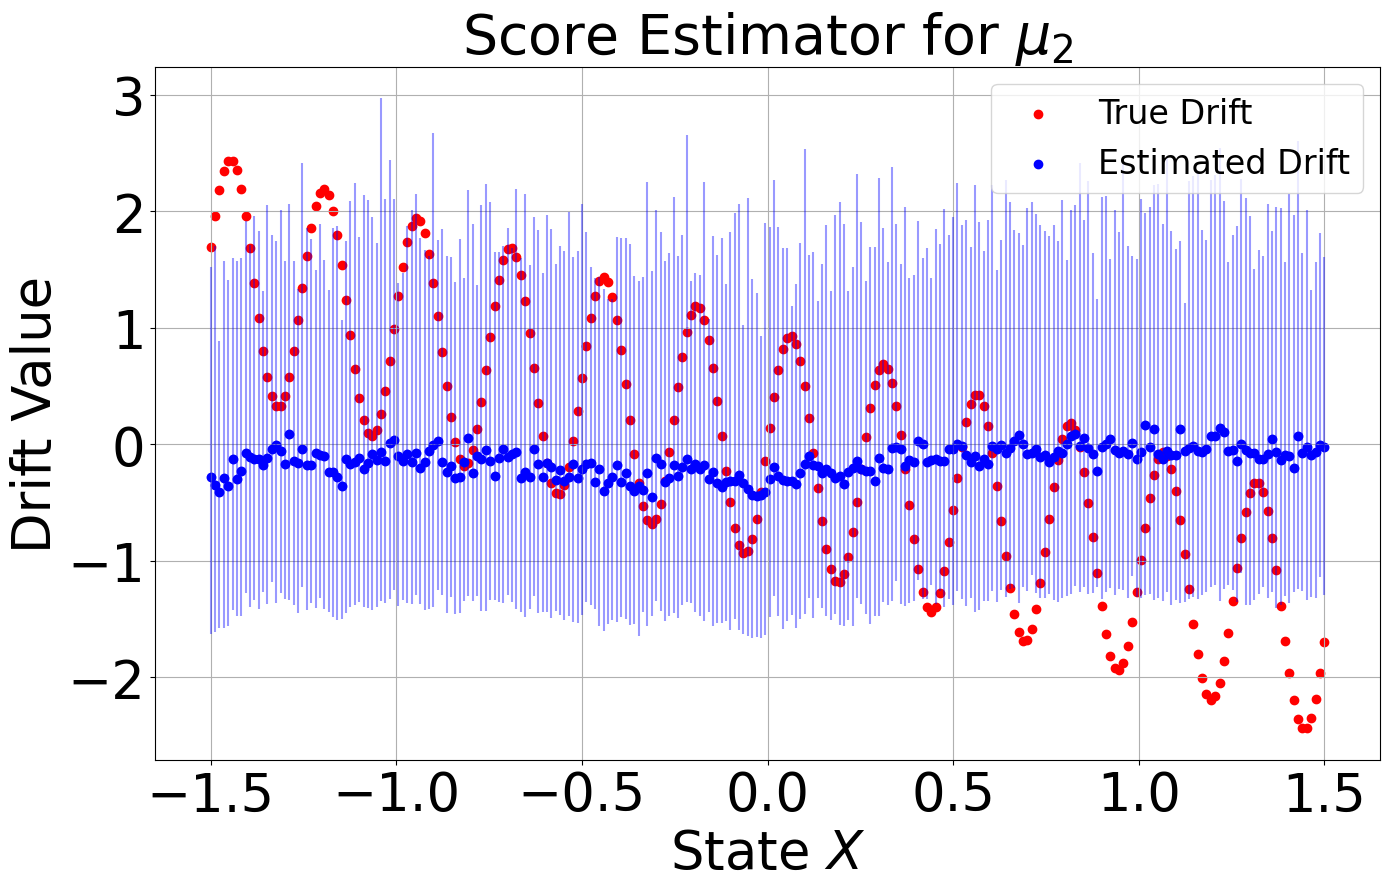

MSE 1.4658671617507935 at Nepoch 50

/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/QuadSinHF2/TSPM_MLP_ST_0002FTh_fQuadSinHF_DriftEvalExp_50Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_BetaMax20e+01_muhats.npy


In [20]:
best_rmse = np.inf
m_mu_hats = []
toSave = False
for f in zip(*[Nepochs_drifteval, driftevalexp_files]):
    Nepoch = f[0]
    file = f[1]
    if Nepoch not in common_epochs: continue
    if Nepoch <0: continue
    try:
        muhats = torch.Tensor(np.load(file, allow_pickle=True))
        Xshape = muhats.shape[0]
        Xs = torch.linspace(-1.5, 1.5, steps=Xshape)
        if "fQuadSin" in config.data_path:
            true_drifts = -2.*config.quad_coeff * Xs.unsqueeze(-1) + config.sin_coeff * config.sin_space_scale*np.sin(config.sin_space_scale*Xs).unsqueeze(-1)
        elif "BiPot" in config.data_path:
            true_drifts = -(4.*config.quartic_coeff * np.power(Xs, 3) + 2.*config.quad_coeff * Xs + config.const).unsqueeze(-1)
        elif "SinLog" in config.data_path:
            true_drifts =  -np.sin(config.sin_space_scale*Xs)*np.log(1+config.log_space_scale*np.abs(Xs))/config.sin_space_scale
        true_drifts = true_drifts.numpy().flatten()
        muhats =  muhats[:, -1, :, 0].reshape(muhats.shape[0], muhats.shape[2]*1)
        mu_hats = muhats.mean(dim=-1) # Pointwise drift estimate
        rmse = rmse_ignore_nans(true_drifts, mu_hats.numpy()).astype(np.float64)
        if rmse < np.inf*best_rmse:
            print(muhats.shape)
            mu_hats_minq = muhats.quantile(dim=-1, q=0.005).numpy() # Lower bound
            mu_hats_maxq = muhats.quantile(dim=-1, q=0.995).numpy() # Upper boun
            best_rmse = rmse
            plot_drift_estimator(mean=mu_hats.numpy(), mean_min=mu_hats_minq, mean_max=mu_hats_maxq, dirname=dirname, numpy_Xs=Xs.numpy(),  toSave=toSave, true_drift=true_drifts, Nepoch=Nepoch, label=label)
            print(f"MSE {rmse} at Nepoch {Nepoch}\n")
            print(file)
    except FileNotFoundError as e:
        print(f"{e}, Hi")
#m_mu_hats = torch.Tensor(np.array(m_mu_hats))
#m_mu_hats = m_mu_hats.numpy()
#mu_hats = m_mu_hats.mean(axis=0)


/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_9722/2436224273.py:12: RuntimeWarning: invalid value encountered in divide
  total_local_errors = np.sqrt(np.mean((all_local_errors), axis=0))/np.sqrt(time_steps)
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_9722/2436224273.py:13: RuntimeWarning: invalid value encountered in divide
  all_errs = np.sqrt(all_local_errors)/np.sqrt(time_steps)


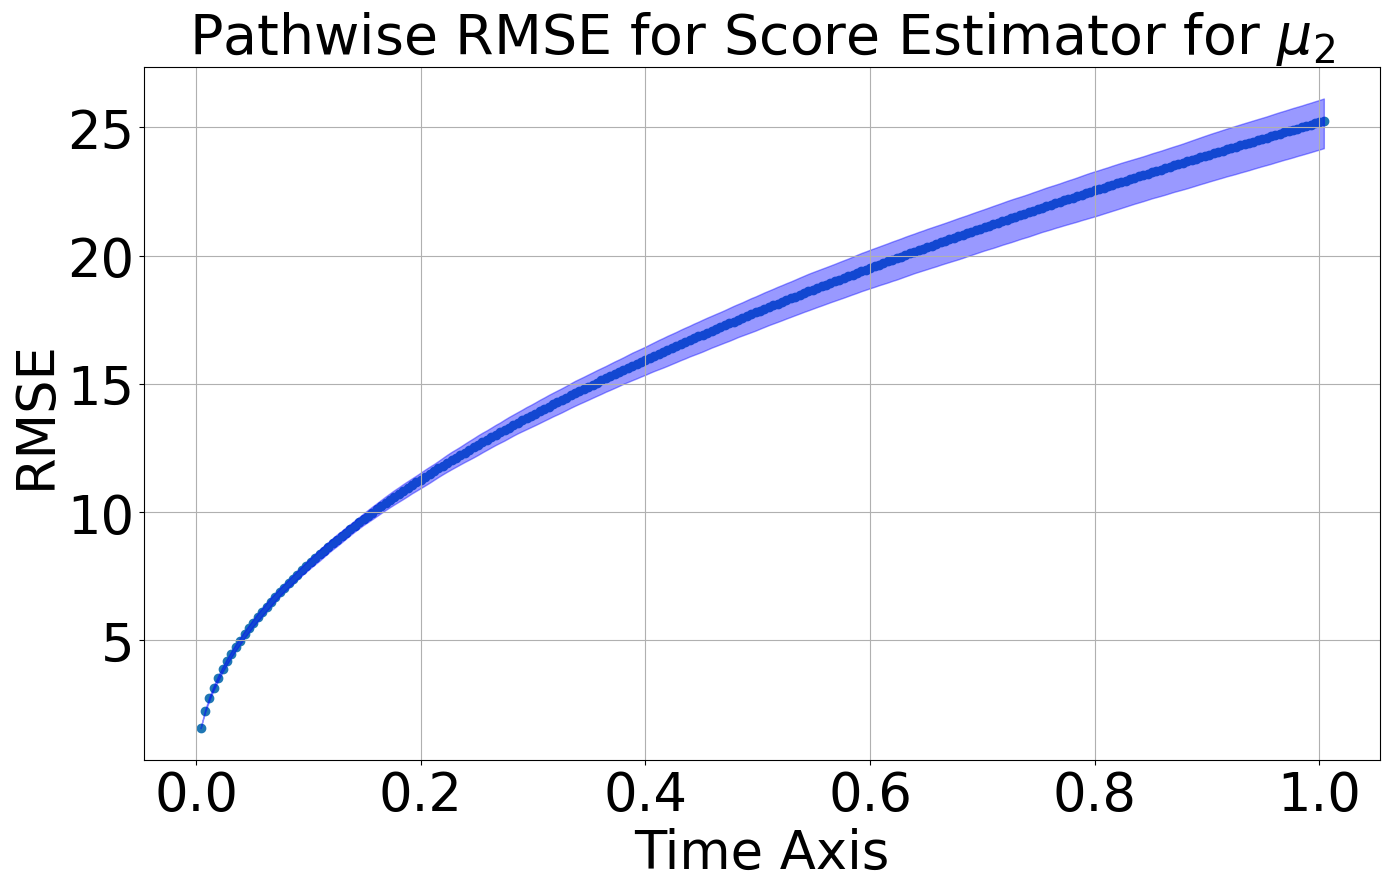

Final time cumulative MSE local-time error 25.247324254124337 with IQR ((24.183296184656598, 26.121404899816614))at Nepoch 25

('/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/QuadSinHF2/TSPM_MLP_ST_0002FTh_fQuadSinHF_OOSDriftTrack_1Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_BetaMax20e+01_true_states.npy', '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/QuadSinHF2/TSPM_MLP_ST_0002FTh_fQuadSinHF_OOSDriftTrack_1Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_BetaMax20e+01_global_states.npy', 25)


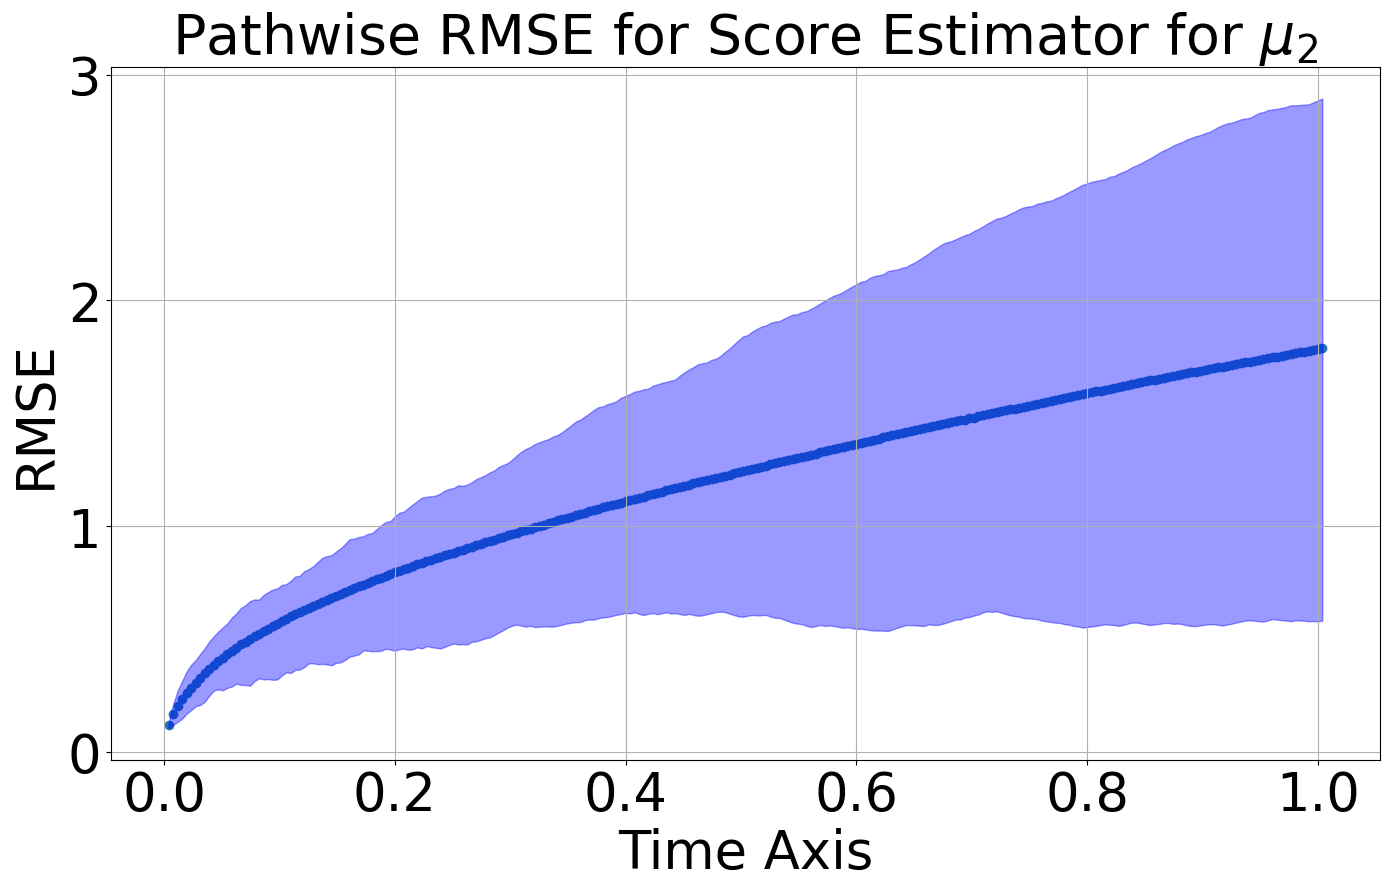

Final time cumulative MSE local-time error 1.7880555472117639 with IQR ((0.5808602188010927, 2.8949990107030925))at Nepoch 50

('/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/QuadSinHF2/TSPM_MLP_ST_0002FTh_fQuadSinHF_OOSDriftTrack_25Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_BetaMax20e+01_true_states.npy', '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/QuadSinHF2/TSPM_MLP_ST_0002FTh_fQuadSinHF_OOSDriftTrack_25Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_BetaMax20e+01_global_states.npy', 50)


In [21]:
curr_rmse = np.inf
toSave = False
i = 0
for file in zip(*[driftoostrack_true_files, driftoostrack_local_files, common_epochs]):
    Nepoch = file[-1]
    all_true_states = np.load(file[0])
    all_local_states = np.load(file[1])
    if (len(all_true_states.shape) == len(all_local_states.shape) == 4):
        time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
        all_local_errors = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        all_local_errors = all_local_errors.reshape(-1, all_local_errors.shape[-1])
        total_local_errors = np.sqrt(np.mean((all_local_errors), axis=0))/np.sqrt(time_steps)
        all_errs = np.sqrt(all_local_errors)/np.sqrt(time_steps)
        total_local_errors[np.isinf(total_local_errors)] = 0.
        all_errs[np.isinf(all_errs)] = 0.
        total_local_errors_minq, total_local_errors_maxq = np.quantile(all_errs, axis=0,q=[0.005,0.995])
        i += 1
        if total_local_errors[-1]  < curr_rmse:
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            plt.grid(True)
            ax.scatter(time_steps, total_local_errors)
            plt.fill_between(time_steps,y1=total_local_errors_minq, y2=total_local_errors_maxq, color="blue", alpha=0.4)
            ax.set_title(f"Pathwise RMSE for Score Estimator for {label}",fontsize=40)

            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)

            fig.canvas.draw()
            # Get the offset text (e.g., '1e-5')
            offset_text = ax.yaxis.get_offset_text().get_text()

            # Remove the offset text from the axis
            ax.yaxis.get_offset_text().set_visible(False)

            # Inject the scale into the y-axis label
            if offset_text:
                ax.set_ylabel(f'RMSE ({offset_text})', fontsize=38)
            else:
                ax.set_ylabel('RMSE', fontsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((root_dir +f"DiffusionModelPresentationImages/TSPM_Markovian/{dirname}/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_{ts_type}_DriftTrack_{Nepoch}Nep_{round(total_local_errors_minq[-1], 7)}_MinIQR_{round(total_local_errors_maxq[-1], 7)}_MaxIQR").replace(".", "")+".png")
            plt.grid(True)
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with IQR ({total_local_errors_minq[-1], total_local_errors_maxq[-1]})at Nepoch {Nepoch}\n")
            print(file)